In [1]:
!python -V

Python 3.8.3


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import  mean_squared_error

In [4]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("newyork_taxi_duration_prediction")

<Experiment: artifact_location='./mlruns/1', creation_time=1673376179250, experiment_id='1', last_update_time=1673376179250, lifecycle_stage='active', name='newyork_taxi_duration_prediction', tags={}>

In [5]:
#read data
df = pd.read_parquet('./data/green_tripdata_2022-01.parquet')

In [6]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,0.50,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,0.50,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,3.25,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,0.50,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,0.50,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75


In [7]:
# calculate duration in  minutes
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() /60)

df = df[(df.duration>=1) & (df.duration<=60)]

categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)

In [8]:
#create dictionary
train_dict= df[categorical+numerical].to_dict(orient='records')
dv= DictVectorizer()
X_train =dv.fit_transform(train_dict)

target ='duration'
Y_train = df[target].values # trim to remove extra zeros

lr = LinearRegression()
lr.fit(X_train, Y_train)

y_predict = lr.predict(X_train)


mean_squared_error(Y_train,y_predict, squared=False)


7.735793552152567

/tmp/ipykernel_13194/875790282.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_predict, label='prediction')
/tmp/ipykernel_13194/875790282.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_train, label='actual')


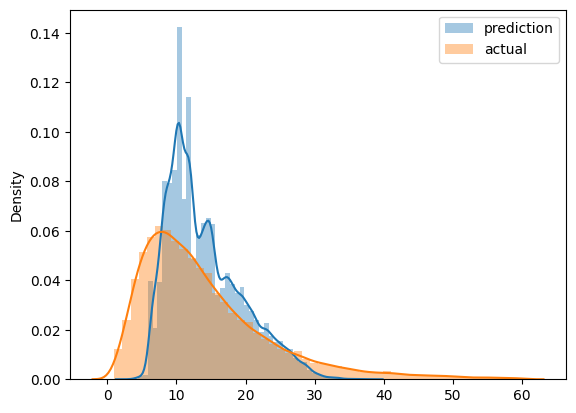

In [9]:
sns.distplot(y_predict, label='prediction')
sns.distplot(Y_train, label='actual')

plt.legend()

In [10]:
def read_data(filename):
    if filename.endswith('csv'):
        df = pd.read_csv(filename)
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('parquet'):
        df = pd.read_parquet(filename)
        
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >=1) & (df.duration <=60)]
    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df


In [11]:
df_train = read_data('./data/green_tripdata_2022-02.parquet')
df_test = read_data('./data/green_tripdata_2022-01.parquet')

In [12]:
len(df_train), len(df_test)

(66097, 59603)

In [13]:
df_test.head(2)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,...,0.5,0.0,0.0,None,0.3,4.8,2.0,1.0,0.0,1.200000
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,...,0.5,0.0,0.0,None,0.3,10.8,2.0,1.0,0.0,8.716667


In [14]:

df_train['PU_DO'] = df_train['PULocationID']+ '_' +df_train['DOLocationID']
df_test['PU_DO'] = df_test['PULocationID']+ '_' +df_test['DOLocationID']
#df_test['PU_DO'] = df_test[categorical].astype(str)


In [15]:
categorical = ['PU_DO']
numerical =['trip_distance']

dv = DictVectorizer()
train_dict = df_train[categorical+numerical].to_dict(orient='records')
X_train= dv.fit_transform(train_dict)

test_dict = df_test[categorical+numerical].to_dict(orient='records')
X_test= dv.transform(test_dict)

In [16]:
target ='duration'
Y_train = df_train[target].values
Y_test = df_test[target].values


In [17]:
lr = LinearRegression()
lr.fit(X_train,Y_train)

y_predict= lr.predict(X_test)
mean_squared_error(Y_test, y_predict, squared=False)

6.745010218324879

In [18]:
with open('model/linear_reg.bin','wb') as f_out:
     pickle.dump((dv,lr),f_out)

In [19]:
with mlflow.start_run():
    
    mlflow.set_tag('Developer','Lenin')
    mlflow.log_param("train-data-path","./data/green_tripdata_2022-02.parquet")
    mlflow.log_param("test-data-path","./data/green_tripdata_2022-01.parquet")
    
    
    alpha =0.1
    mlflow.log_param("alpha",alpha)
    
    lr = Lasso(0.001)
    lr.fit(X_train, Y_train)

    Y_predict = lr.predict(X_test)

    rmse = mean_squared_error(Y_test, Y_predict, squared=False)
    mlflow.log_metric("rmse",rmse)


In [20]:
lr = Ridge()
lr.fit(X_train, Y_train)

Y_predict = lr.predict(X_test)

mean_squared_error(Y_test, Y_predict, squared=False)


6.961662981883177

In [21]:
import xgboost as xgb
from hyperopt import fmin,tpe,hp,STATUS_OK, Trials
from hyperopt.pyll import scope

In [22]:
#Disable autologing, mlflow wont track any parameters automatically
#Default False
mlflow.xgboost.autolog(disable=True)


In [23]:
train = xgb.DMatrix(X_train,label=Y_train)
test = xgb.DMatrix(X_test,label=Y_test)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params =params,
            dtrain=train,
            num_boost_round=10,
            #num_boost_round=10,
            evals=[(test, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(test)
        rmse = mean_squared_error(Y_test, y_predict, squared=False)
        mlflow.log_metric("rmse", rmse)
        
        mlflow.log_artifact("model/preprocessor.b", artifact_path="preprocessor")
        
        with open("model/preprocessor.b", "wb") as f_out:
            pickle.dump(dv,f_out)
        
        mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    return {'loss': rmse, 'status': STATUS_OK}

In [24]:
 search_space ={
    'max_depth':scope.int(hp.quniform('max_depth',4,100,1)),
    'learning_rate':hp.loguniform('learning_rate',-3,0),
    'reg_alpha':hp.loguniform('reg_alpha',-5,-1),
    'reg_lambda':hp.loguniform('reg_lambda',-6,-1),
    'min_child_weight':hp.loguniform('min_child_weight',-1,3),
    'objective':'reg:linear',
    'seed':42
}
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[15:37:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.              
[0]	validation-rmse:15.50654                                                                                                        
[1]	validation-rmse:14.54682                                                                                                        
[2]	validation-rmse:13.66087                                                                                                        
[3]	validation-rmse:12.84863                                                                                                        
[4]	validation-rmse:12.09936                                                                                                        
[5]	validation-rmse:11.41662                                                                                                        
[6]	validation-rmse:10.79054                                         

[5]	validation-rmse:6.75260                                                                                                         
[6]	validation-rmse:6.31589                                                                                                         
[7]	validation-rmse:6.03854                                                                                                         
[8]	validation-rmse:5.85556                                                                                                         
[9]	validation-rmse:5.74852                                                                                                         
[15:38:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.              
[0]	validation-rmse:6.59384                                                                                                         
[1]	validation-rmse:5.69990                                          

[0]	validation-rmse:13.65794                                                                                                        
[1]	validation-rmse:11.40025                                                                                                        
[2]	validation-rmse:9.67679                                                                                                         
[3]	validation-rmse:8.38439                                                                                                         
[4]	validation-rmse:7.44362                                                                                                         
[5]	validation-rmse:6.79048                                                                                                         
[6]	validation-rmse:6.34618                                                                                                         
[7]	validation-rmse:6.06472                                          

[6]	validation-rmse:7.11359                                                                                                         
[7]	validation-rmse:6.65775                                                                                                         
[8]	validation-rmse:6.32722                                                                                                         
[9]	validation-rmse:6.08166                                                                                                         
[15:39:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.              
[0]	validation-rmse:15.18959                                                                                                        
[1]	validation-rmse:13.96702                                                                                                        
[2]	validation-rmse:12.87068                                         

[1]	validation-rmse:15.05131                                                                                                        
[2]	validation-rmse:14.36570                                                                                                        
[3]	validation-rmse:13.72065                                                                                                        
[4]	validation-rmse:13.11364                                                                                                        
[5]	validation-rmse:12.54293                                                                                                        
[6]	validation-rmse:12.00834                                                                                                        
[7]	validation-rmse:11.50608                                                                                                        
[8]	validation-rmse:11.03618                                         

[7]	validation-rmse:7.08175                                                                                                         
[8]	validation-rmse:6.68892                                                                                                         
[9]	validation-rmse:6.38905                                                                                                         
[15:39:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.              
[0]	validation-rmse:15.41644                                                                                                        
[1]	validation-rmse:14.38208                                                                                                        
[2]	validation-rmse:13.43548                                                                                                        
[3]	validation-rmse:12.57260                                         

[2]	validation-rmse:12.09769                                                                                                        
[3]	validation-rmse:10.98843                                                                                                        
[4]	validation-rmse:10.04308                                                                                                        
[5]	validation-rmse:9.22887                                                                                                         
[6]	validation-rmse:8.54048                                                                                                         
[7]	validation-rmse:7.95660                                                                                                         
[8]	validation-rmse:7.47424                                                                                                         
[9]	validation-rmse:7.07854                                          

[8]	validation-rmse:5.69347                                                                                                         
[9]	validation-rmse:5.69074                                                                                                         
[15:41:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.              
[0]	validation-rmse:13.11913                                                                                                        
[1]	validation-rmse:10.61466                                                                                                        
[2]	validation-rmse:8.83486                                                                                                         
[3]	validation-rmse:7.61972                                                                                                         
[4]	validation-rmse:6.83174                                          

[3]	validation-rmse:6.10446                                                                                                         
[4]	validation-rmse:5.76771                                                                                                         
[5]	validation-rmse:5.64397                                                                                                         
[6]	validation-rmse:5.61194                                                                                                         
[7]	validation-rmse:5.60819                                                                                                         
[8]	validation-rmse:5.61371                                                                                                         
[9]	validation-rmse:5.62444                                                                                                         
[15:41:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linea

[9]	validation-rmse:7.18634                                                                                                         
100%|██████████████████████████████████████████████████████████████| 50/50 [04:36<00:00,  5.54s/trial, best loss: 6.745010218324879]


In [25]:
logged_model = 'runs:/abf5c4d867d34d12932a75621fd50e88/models_mlflow'


In [26]:
logged_model

'runs:/abf5c4d867d34d12932a75621fd50e88/models_mlflow'

In [32]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in(RandomForestRegressor, GradientBoostingRegressor,ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():
        mlflow.log_param("train-data-path","./data/green_tripdata_2022-02.parquet")
        mlflow.log_param("test-data-path","./data/green_tripdata_2022-01.parquet")
        mlflow.log_artifact("model/preprocessor.b", artifact_path="preprocessor")
        
        mlmodel = model_class()
        mlmodel.fit(X_train, Y_train)
        
        Y_pred= mlmodel.predict(X_test)
        rmse = mean_squared_error(Y_test,Y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

/home/forkbo/p3_envs/env1/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
